# Create proper dataset for learning

Out of many different CSV files record parametres of the platform during docking, only valueble information has to be extracted. 
Those informations are:
- Distance form the wall
- Rotation
- Distance setpoint
- Distance needed for docking
- Time of docking
- Base speed

In [1]:
import os
import pandas as pd
import csv
import numpy as np
import random

In [2]:
file = 'ride85'
path = '../scripts/logs/portenta/' + file + '.csv'

df_procedure = pd.read_csv(path, skiprows=[0,1,2,3], names=['time[s]',
                                                          'front[mm]', 
                                                          'rear[mm]', 
                                                          'PID Align setpoint', 
                                                          'PID Distance setpoint', 
                                                          'error[mm]', 
                                                          'angle[rad]', 
                                                          'distance[mm]', 
                                                          'rw_speed[rad/s]', 
                                                          'lw_speed[rad/s]', 
                                                          'pozyx_x_1', 
                                                          'pozyx_y_1',
                                                          'pozyx_rot_y_1', 
                                                          'pozyx_x_2',
                                                          'pozyx_y_2',
                                                          'pozyx_rot_2'
                                                        ])
df_single = pd.read_csv(path, skiprows=lambda x: x>2, index_col=0, header=None).T

docking_time = df_procedure.iloc[-1]['time[s]']
docking_distance = df_procedure.iloc[-1]['front[mm]']
base_speed = df_procedure.iloc[-1]['rear[mm]']

df_procedure = df_procedure[:-1]



In [3]:
print(df_procedure.tail())

          time[s]  front[mm]  rear[mm] PID Align setpoint  \
415  1.661456e+09      387.5     373.5                0.0   
416  1.661456e+09      387.5     373.5                0.0   
417  1.661456e+09      388.0     375.0                0.0   
418  1.661456e+09      388.0     375.0                0.0   
419  1.661456e+09      385.0     379.0                0.0   

    PID Distance setpoint error[mm]           angle[rad]       distance[mm]  \
415                 500.0      14.0  0.03886930217792175  547.8081410839814   
416                 500.0      14.0  0.03886930217792175  547.8081410839814   
417                 500.0      13.0  0.03609542693579677  548.6701579950827   
418                 500.0      13.0  0.03609542693579677  548.6701579950827   
419                 500.0       6.0  0.01666512371394075  548.0905482650408   

        rw_speed[rad/s]     lw_speed[rad/s] pozyx_x_1 pozyx_y_1  \
415   1.345782995223999  0.6921169757843018     1.376     0.988   
416   1.345782995223999 

In [4]:
# Procdure
front_sensor = df_procedure.iloc[0, 1]
rear_sensor = df_procedure.iloc[0, 2]
pid_align_setpoint = df_procedure.iloc[0, 3]
pid_distance_setpoint = df_procedure.iloc[0, 4]
error = df_procedure.iloc[0, 5]
angle = df_procedure.iloc[0, 6]
distance = df_procedure.iloc[0, 7]

row = [base_speed,
       front_sensor,
       rear_sensor, 
       pid_align_setpoint, 
       pid_distance_setpoint,
       error, 
       angle, 
       distance,
       docking_time, 
       docking_distance
       ]

print(f'{base_speed=},{front_sensor=}, {rear_sensor=}, {pid_align_setpoint=}, {pid_distance_setpoint=}, {error=}, {angle=}, {distance=}, {docking_time=}, {docking_distance=}')

base_speed=1.0,front_sensor=446.0, rear_sensor=86.0, pid_align_setpoint='0.3', pid_distance_setpoint='500.0', error='360.0', angle='0.7853981633974482', distance='354.2604973744604', docking_time=9.057978630065918, docking_distance=895.0


## Create plots

In [5]:
import matplotlib.pyplot as plt

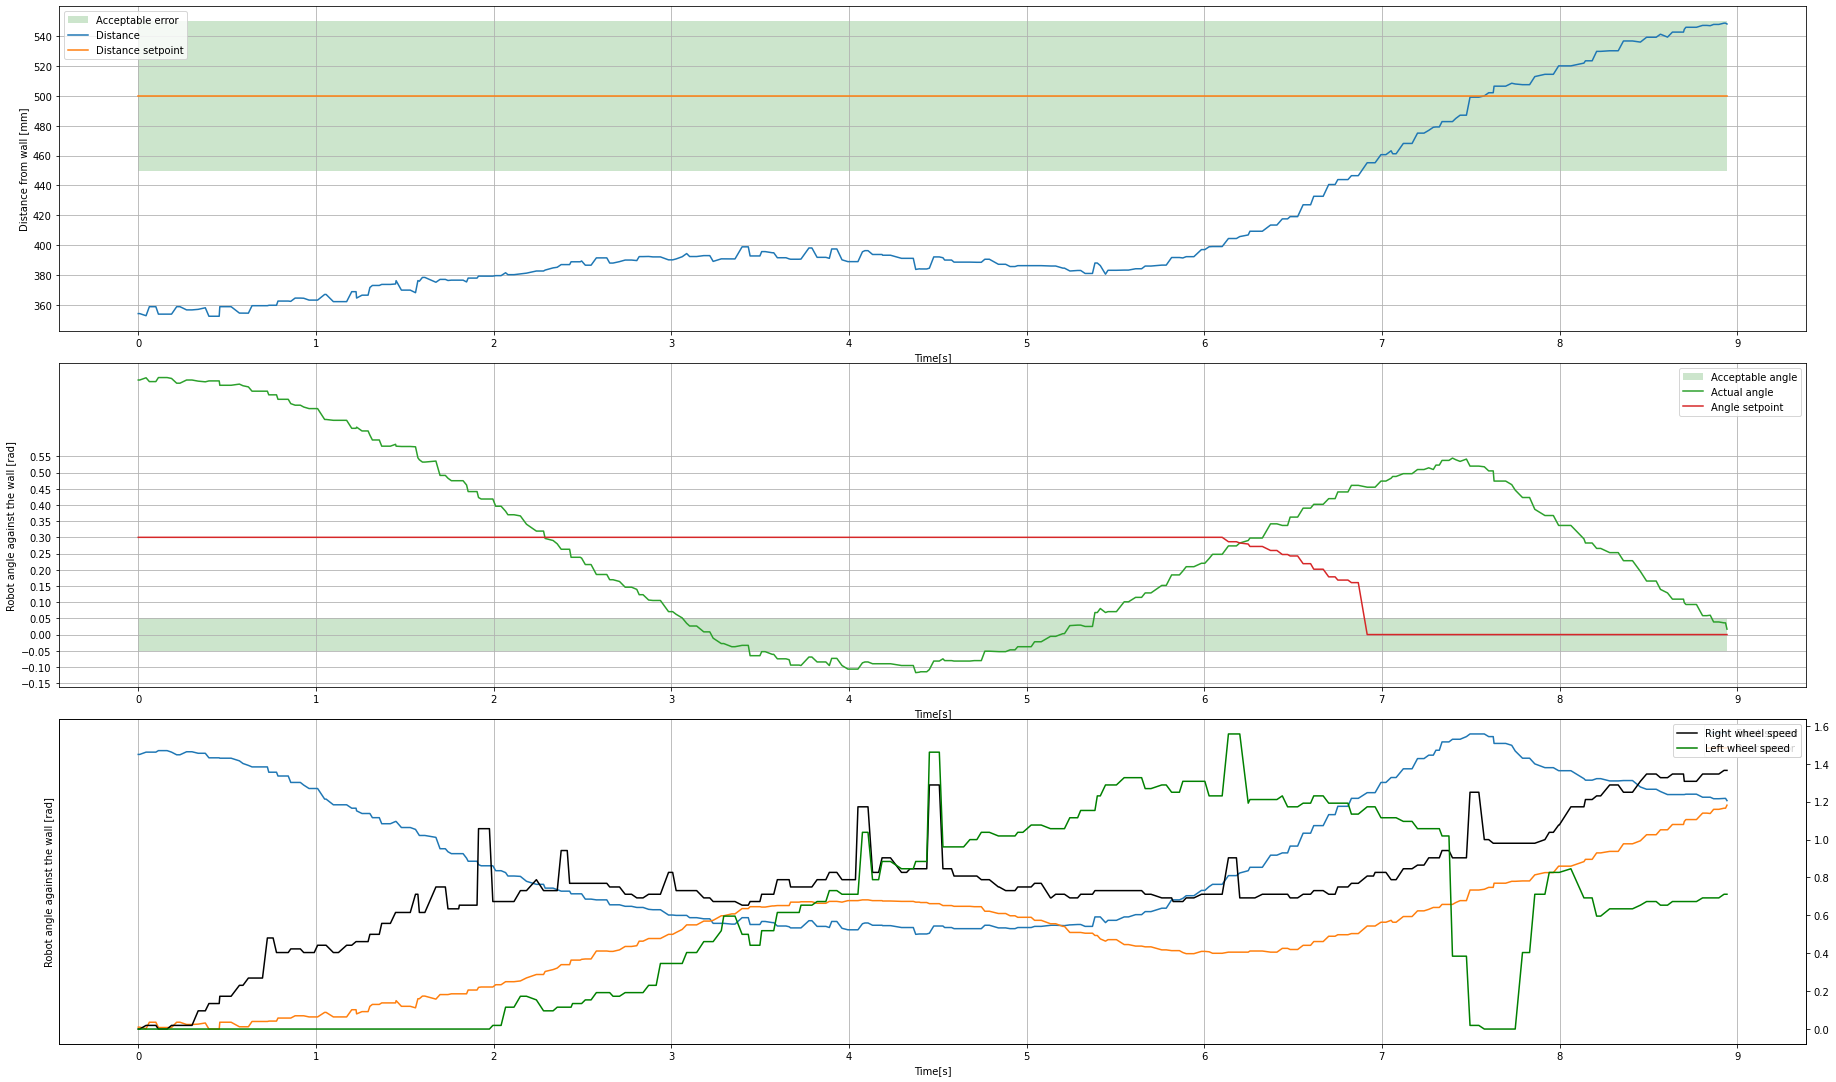

In [6]:

df_procedure['time[s]'] = df_procedure['time[s]'] - df_procedure.iloc[0,0]

time = df_procedure['time[s]'].values.tolist()
# df_procedure['distance[mm]'] = df_procedure['distance[mm]'].interpolate()
distance = df_procedure['distance[mm]'].astype('float').values.tolist()
angle = df_procedure['angle[rad]'].astype('float').values.tolist()
pid_distance_setpoint = df_procedure['PID Distance setpoint'].astype('float').values.tolist()
pid_align_setpoint = df_procedure['PID Align setpoint'].astype('float').values.tolist()
pozyx_x_1 = df_procedure['pozyx_x_1'].astype('float').values.tolist()

min_distance = (df_procedure['PID Distance setpoint'].astype('float') - 50).values.tolist()
max_distance = (df_procedure['PID Distance setpoint'].astype('float') + 50).values.tolist()

front_sensor = df_procedure['front[mm]'].astype('float').values.tolist()
rear_sensor = df_procedure['rear[mm]'].astype('float').values.tolist()
right_wheel_speed = df_procedure['rw_speed[rad/s]'].astype('float').values.tolist()
left_wheel_speed = df_procedure['lw_speed[rad/s]'].astype('float').values.tolist()

fig, axs = plt.subplots(3)

fig.set_size_inches(25,15)
plt.tight_layout()    

axs[0].yaxis.set_ticks(np.arange(100, 1100, 20))
axs[0].xaxis.set_ticks(np.arange(0, 20, 1))
axs[0].set_xlabel('Time[s]')
axs[0].set_ylabel('Distance from wall [mm]')
axs[0].fill_between(time, min_distance, max_distance, facecolor='green', alpha=0.2)
axs[0].plot(time, distance)
axs[0].plot(time, pid_distance_setpoint)
# axs[0].plot(time, pozyx_x_1)
axs[0].grid()
axs[0].legend(['Acceptable error', 'Distance', 'Distance setpoint'])

# Recalculate
D = 195
error = 10
angle_from_error = np.arcsin(error/np.sqrt(D**2+error**2))
min_angle = list([angle_from_error] * len(time))
max_angle = [-angle_from_error] * len(time)

axs[1].yaxis.set_ticks(np.arange(-0.6, 0.6, 0.05))
axs[1].xaxis.set_ticks(np.arange(0, 20, 1))
axs[1].set_xlabel('Time[s]')
axs[1].set_ylabel('Robot angle against the wall [rad]')
axs[1].fill_between(time, min_angle, max_angle, facecolor='green', alpha=0.2)
axs[1].plot(time, angle, 'tab:green')
axs[1].plot(time, pid_align_setpoint, 'tab:red')
axs[1].grid()
axs[1].legend(['Acceptable angle', 'Actual angle', 'Angle setpoint'])


axs[2].yaxis.set_ticks(np.arange(-0.6, 0.6, 0.05))
axs[2].xaxis.set_ticks(np.arange(0, 20, 1))
axs[2].set_xlabel('Time[s]')
axs[2].set_ylabel('Robot angle against the wall [rad]')
axs[2].plot(time, front_sensor)
axs[2].plot(time, rear_sensor)
ax2 = axs[2].twinx()
# axs[2].plot(time, right_wheel_speed)
# axs[2].plot(time, left_wheel_speed)
ax2.plot(time, right_wheel_speed, color='black')
ax2.plot(time, left_wheel_speed, color='green')
axs[2].grid()
axs[2].legend(['Front sensor', 'Rear sensor'], loc=0)
ax2.legend(['Right wheel speed', 'Left wheel speed'])



### Generate plot for each docking 

In [ ]:
def generate_plot(df):
    pass

In [106]:
# Get list of CSV files

In [ ]:
# for each file generate plot and save

## Create training data

In [7]:
docking_procedures = [ '../scripts/logs/portenta/' + el for el in os.listdir('../scripts/logs/portenta/') if '.csv' in el ]

In [8]:
'ride10.csv' in docking_procedures

False

In [27]:
names=['front[mm]',
       'rear[mm]', 
       'PID Align setpoint', 
       'error[mm]', 
       'angle[rad]', 
       'distance[mm]', 
]

training_data = pd.DataFrame(columns=names+['docking_distance[mm]'])
i = 0
for docking in docking_procedures:
  df_procedure = pd.read_csv(docking, skipinitialspace=True, usecols=names)
  new_row = dict(df_procedure.iloc[0].astype('float'))
  try:
    new_row['docking_distance[mm]'] = float(df_procedure.iloc[-1]['front[mm]'])
  except:
    new_row['docking_distance[mm]'] = 45
  training_data = training_data.append(new_row, ignore_index=True)

In [28]:
training_data

,front[mm],rear[mm],PID Align setpoint,error[mm],angle[rad],distance[mm],docking_distance[mm]
0,205.5,221.0,0.300000,-15.5,-0.043029,374.888791,425.0
1,432.0,367.5,-0.204730,64.5,0.177286,568.243208,460.0
2,1081.5,683.0,-0.300000,398.5,0.836113,753.969569,575.0
3,852.0,760.0,-0.300000,92.0,0.250201,958.097644,1495.0
4,416.5,434.5,-0.258803,-18.0,-0.049958,586.267623,495.0
...,...,...,...,...,...,...,...
94,43.5,-14.5,0.300000,58.0,0.159738,188.348970,880.0
95,180.0,161.0,0.300000,19.0,0.052729,338.723017,520.0
96,582.5,577.0,-0.300000,5.5,0.015277,745.732419,630.0
97,656.5,285.5,0.000000,371.0,0.800445,493.139059,45.0


### Seaborn

In [29]:
import seaborn as sns
np.set_printoptions(precision=3, suppress=True)

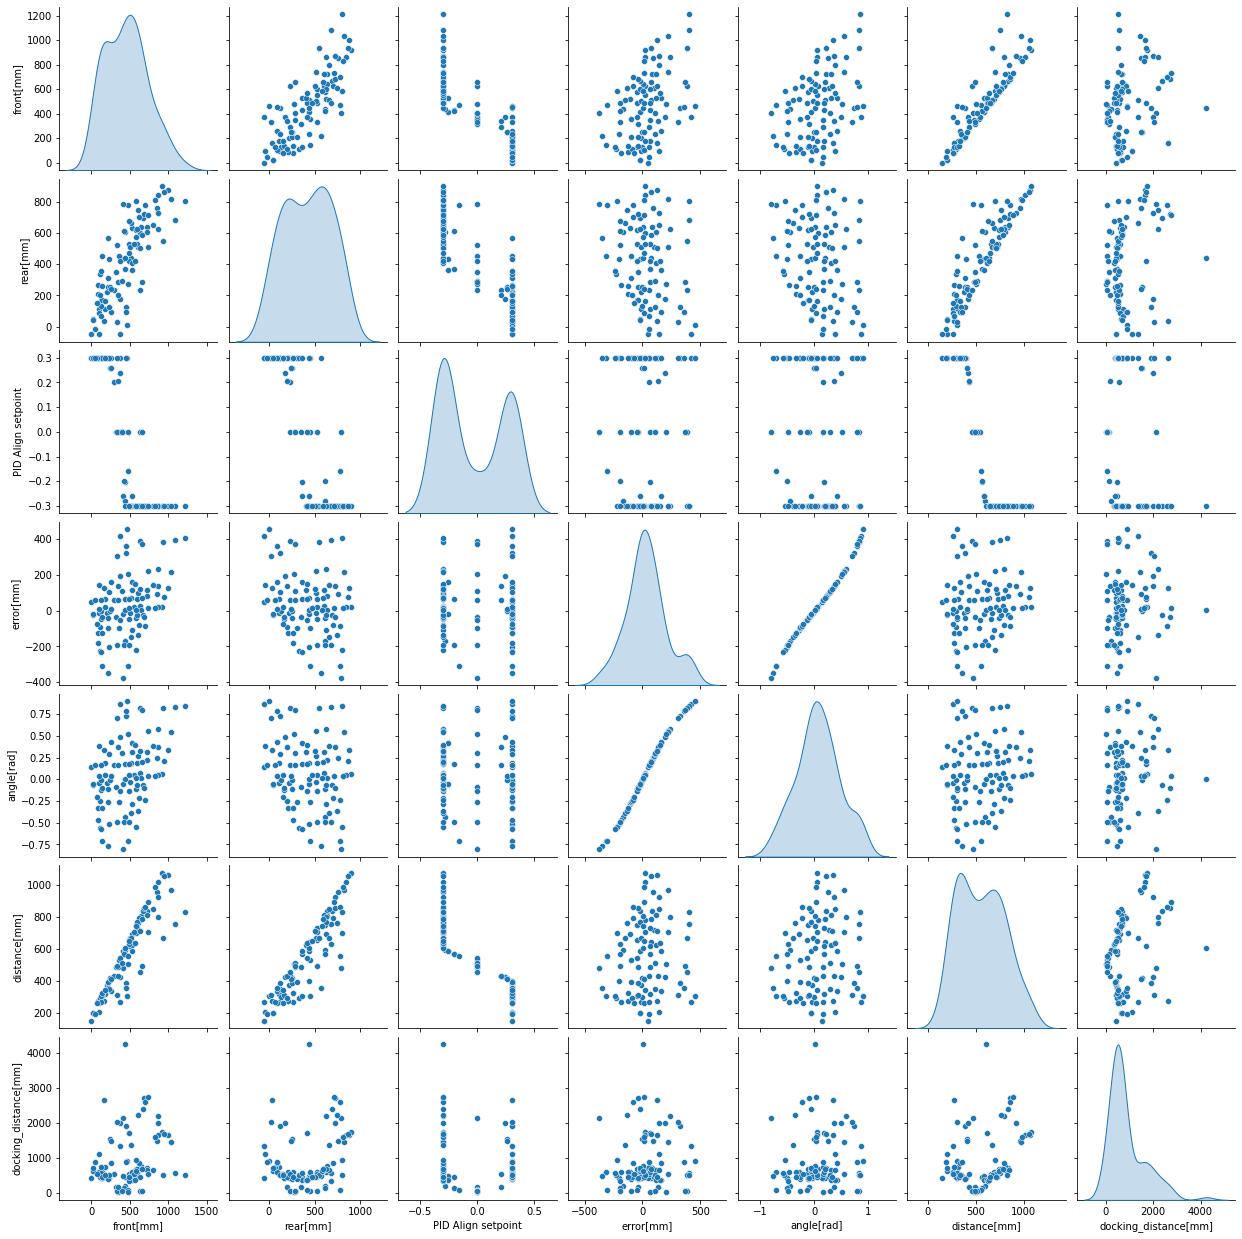

In [30]:
plot=sns.pairplot(training_data, diag_kind='kde')

# OLD

In [2]:
def clear_data(df):
        start_time = df.iloc[0,7]
        df = df[df['distance[mm]'] > 150.0]
        df['time[s]'] = df['time[s]'] - start_time
        df = df.apply(pd.to_numeric)

        return df

In [18]:
path = 'training_data_2.csv'

In [12]:
path = 'extended_training_data_2.csv'

In [13]:
def add_noise(value):
    value += np.random.normal(0, 1) * value/100
    return value

In [14]:
add_noise(1)

0.9939767975405991

In [20]:
f = open(path, 'w')
writer = csv.writer(f)


writer.writerow(['base_speed',
                'front[mm]', 
                'rear[mm]', 
                'PID Align setpoint', 
                'PID Distance setpoint', 
                'error[mm]', 
                'angle[rad]', 
                'distance[mm]', 
                'docking_time', 
                'docking_distance'
            ])


for n in range(25):

    try:
        file = 'ride_' + str(n)  + '.csv'
        path = '../scripts/logs/500_2/' + file


        df_procedure = pd.read_csv(path, skiprows=[0,1,2, 3], names=['time[s]',
                                                          'front[mm]', 
                                                          'rear[mm]', 
                                                          'PID Align setpoint', 
                                                          'PID Distance setpoint', 
                                                          'error[mm]', 
                                                          'angle[rad]', 
                                                          'distance[mm]', 
                                                          'rw_speed[rad/s]', 
                                                          'lw_speeed[rad/s]', 
                                                          'pozyx_x_1', 
                                                          'pozyx_y_1',
                                                          'pozyx_rot_y_1', 
                                                          'pozyx_x_2',
                                                          'pozyx_y_2',
                                                          'pozyx_rot_2'
                                                        ])
        df_single = pd.read_csv(path, skiprows=lambda x: x>2, index_col=0, header=None).T

        base_speed = df_single.iloc[0,2]

        # Procdure
        front_sensor = df_procedure.iloc[0, 1]
        rear_sensor = df_procedure.iloc[0, 2]
        pid_align_setpoint = df_procedure.iloc[0, 3]
        pid_distance_setpoint = df_procedure.iloc[0, 4]
        error = df_procedure.iloc[0, 5]
        angle = df_procedure.iloc[0, 6]
        distance = df_procedure.iloc[0, 7]

        # Single
        docking_time = df_single.iloc[0,0]
        docking_distance = df_single.iloc[0,1]

        row = [base_speed,
            front_sensor,
            rear_sensor, 
            pid_align_setpoint, 
            pid_distance_setpoint,
            error, 
            angle, 
            distance,
            docking_time, 
            docking_distance
            ]

        print(row)
        writer.writerow(row)
    except:
        print(n)


f.close()

[2.5, 103.0, 98.0, -0.2458527631418588, 500.0, -5.0, -0.0256354085216774, 254.1472368581412, 10.419591426849363, 1355.0]
[2.5, 679.0, 692.0, 0.3, 500.0, 13.0, 0.0665681637758238, 811.6792369444722, 9.662449836730955, 1320.0]
[2.5, 439.0, 439.0, 0.0855461467153579, 500.0, 0.0, 0.0, 585.546146715358, 6.75080156326294, 870.0]
3
[2.5, 522.0, 526.0, 0.1692721603430832, 500.0, 4.0, 0.0205099441394465, 669.2721603430832, 9.610530138015749, 1200.0]
[2.5, 195.0, 204.0, -0.1563444273730264, 500.0, 9.0, 0.0461211160145112, 343.6555726269736, 18.49069333076477, 2431.0]
[2.5, 659.0, 668.0, 0.3, 500.0, 9.0, 0.0461211160145112, 800.9993109335679, 10.292529344558716, 1377.0]
7
[2.5, 270.0, 259.0, -0.0721497243110861, 500.0, -11.0, -0.0563505357126421, 427.8502756889139, 5.187043905258179, 641.0]
[2.5, 520.0, 527.0, 0.1640088275786613, 500.0, 7.0, 0.0358820283531573, 664.0088275786613, 7.082317590713501, 908.0]
[2.5, 752.0, 763.0, 0.3, 500.0, 11.0, 0.0563505357126421, 885.4320020129604, 14.484589338302

In [235]:
path = 'extended_training_data.csv'
f = open(path, 'w')
writer = csv.writer(f)


writer.writerow(['base_speed',
                 'distance_from_wall', 
                 'rotation_angle', 
                 'distance_setpoint', 
                 'docking_time', 
                 'docking_distance'])


for n in range(49):

    try:
        file = 'ride_' + str(n)  + '.csv'
        path = '../scripts/logs/measurements/' + file
        df = pd.read_csv(path)

        docking_time = df.iloc[-3,1]
        docking_distance = df.iloc[-2,1]
        base_speed = df.iloc[-1,1]
        df = clear_data(df)
        distance_from_wall = df.iloc[0,6]
        rotation_angle = df.iloc[0, 5]
        distance_setpoint = df.iloc[0,3]

        for m in range(100):

            row = [base_speed,
            add_noise(distance_from_wall),
            add_noise(rotation_angle), 
            distance_setpoint, 
            add_noise(docking_time), 
            add_noise(docking_distance)]

            # print(row)
            writer.writerow(row)
    except:
        print(n)


f.close()

/tmp/ipykernel_37068/3733329275.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['time[s]'] = df['time[s]'] - start_time


18
26
27
48
